# Data generation

**NOTE**: Only need to run this notebook if you have the raw data from `MORIA` and want to reconstuct the data used in the modeling. Otherwise just simply use the `hdf5` stored in this repository.

In any experimental run in `GALADRIEL`, thousands of shots are generated and several diagnostics/tools measure the parameters and results. Tha data is  stored in `MORIA` (a MongoDB database).

The data required for the ML modeling in this repository is:
- Input Dazzler coefficients (and goodness)
- Pulse shape

Dazzler coefficients used in the experimtal run can easily been extracted from `Moria`. However pulse reconstruction data directly from `Wizzler` has a very low resolution (~20 points). To overcome this issue, we can reconstruct the pulse usig the method desribed in ["High-resolution direct phase control in the spectral domain in ultrashort pulse lasers for pulse-shaping applications"](https://doi.org/10.1088/1748-0221/20/05/P05002). In this notebook we use that algorithm to reconstruct the pulse shape with the desired resolution (in our case, 200 points). To run it we need the frequency, intensity and phase captured by the Wizzler.

This notebooks assumes that the data (Dazzler, wizzler...) is a in a `hdf5` file previously pulled from `MORIA` . And it returns a new `hdf5` file winth only the Dazzler coefficients and pulse shapes from the experiment. This notebook only needs to be executed once. This way that data can be used for model training/testing without recalculating pulse shapes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pulse


## READ DATASET

In [2]:
#READ DATASET (HR) FROM Galadriel database
filename='../laps-ml/datasets/galadriel_dataset_24_09_18_high_res.h5'

#read the Dazller input data
df_input=pd.read_hdf(filename,'df_input')

#Extract values from spec
df_spec_freq=pd.read_hdf(filename,'df_spec_freq')
df_spec_int=pd.read_hdf(filename,'df_spec_int')
df_spec_phase=pd.read_hdf(filename,'df_spec_phase')

#Extract time and intensity (calculated by Wizzler) for comparison
df_time=pd.read_hdf(filename,'df_time')
df_time_val=df_time.loc[0]
df_pulse_wizz= df_time.drop([0]) #drop the time values
df_pulse_wizz.reset_index(inplace=True,drop=True)


In [3]:
#time in fs (it is the boundariy)
def pulse_reconst(df_spec_int,df_spec_freq,df_spec_phase,time=100,time_bins=100):
    t = np.linspace(-time,time,time_bins+1)#*1e-15   ## time array, in fs.
    c = 299792458 ## speed of light in m/s
    center_freq = c/800e-9  ## define the center frequency using the known center wavelength of GALADRIEL, 800nm
    
    p_list=[]
    for i in range(0,len(df_spec_freq)):
        intensity=df_spec_int.loc[i].to_numpy()
        frequency=df_spec_freq.loc[i].to_numpy()
        phase=df_spec_phase.loc[i].to_numpy()
        p = pulse.pulse(t,frequency*1e12,intensity,phase,wavelength=False,center=center_freq)
        p_list.append(p.intensity)
    
    return t,pd.DataFrame(p_list)

In [ ]:
####RECONSTRUCT PULSES
write_data=False #set to True to write the reconstructed pulse data to an hdf5 file
                #(it can take a few minutes to run the pulse reconstruction,
                #set to False by default)
output_filename='pulse_and_dazzler_240918.h5'
if write_data:
    t_200,df_pulse_200=pulse_reconst(df_spec_int,df_spec_freq,df_spec_phase,time=150,time_bins=200)

    ###write to hdf5 file
    pd.DataFrame(t_200).to_hdf(output_filename,'df_time_200',mode='w')
    df_pulse_200.to_hdf(output_filename,'df_pulse_200')
    df_input.to_hdf(output_filename,'df_input')

/tmp/ipykernel_28347/2714276003.py:8: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  pd.DataFrame(t_200).to_hdf(output_filename,'df_time_200',mode='w')
/tmp/ipykernel_28347/2714276003.py:9: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df_pulse_200.to_hdf(output_filename,'df_pulse_200')
/tmp/ipykernel_28347/2714276003.py:10: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  df_input.to_hdf(output_filename,'df_input')


## Testing the results

In [22]:
#READ HDF5 to verify data
df_time_200=pd.read_hdf(output_filename,'df_time_200')
df_pulse_200=pd.read_hdf(output_filename,'df_pulse_200')
df_input_read=pd.read_hdf(output_filename,'df_input')
t_200=df_time_200.to_numpy()

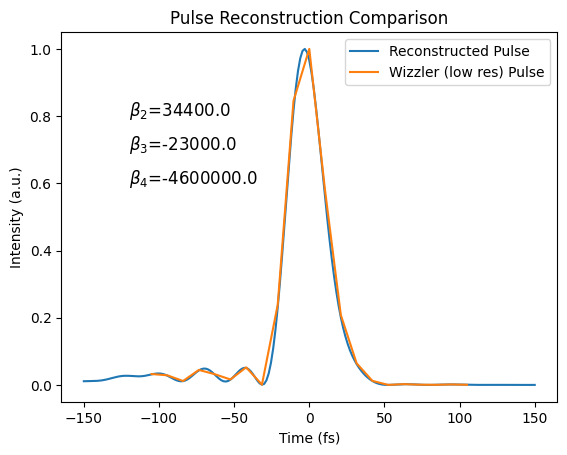

In [26]:
rand_index=30
plt.plot(t_200,df_pulse_200.loc[rand_index],label='Reconstructed Pulse')
plt.plot(df_time_val.values,df_pulse_wizz.loc[rand_index],label='Wizzler (low res) Pulse')
plt.xlabel('Time (fs)')
plt.ylabel('Intensity (a.u.)')
#plot text
plt.text(-120,0.8,r'$\beta_2$='+str(df_input_read['order2'].iloc[rand_index]),fontsize=12)
plt.text(-120,0.7,r'$\beta_3$='+str(df_input_read['order3'].iloc[rand_index]),fontsize=12)
plt.text(-120,0.6,r'$\beta_4$='+str(df_input_read['order4'].iloc[rand_index]),fontsize=12)
plt.legend()
plt.title('Pulse Reconstruction Comparison')
plt.show()